In [29]:
# 100K parameters and 92% accuracy on LFW database
#
#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np

from matplotlib import pyplot as plt

#!pip install statsmodels --upgrade

In [30]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

In [31]:
from scipy.misc import imresize 
from  skimage import transform

In [32]:
# Load
X_train_original = np.load('gender/x_train.npy')
X_test_original = np.load('gender/x_test.npy')

y_train_original = np.load('gender/y_train.npy')
y_test_original = np.load('gender/y_test.npy')

## Transforms
x_train = X_train_original.astype('float32')
x_test = X_test_original.astype('float32')

y_train = y_train_original.astype('float32')
y_test = y_test_original.astype('float32')

x_train /= 255
x_test /= 255

num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10585, 100, 100, 3)
(2648, 100, 100, 3)
(10585, 2)
(2648, 2)


In [33]:
new_shape = (25,25,3)
x_train = np.asarray([transform.resize(image, new_shape) for image in x_train])
x_test = np.asarray([transform.resize(image, new_shape) for image in x_test])

In [34]:
x_train[3,:,:,:]

array([[[0.34254354, 0.40747893, 0.35437173],
        [0.34889346, 0.40109208, 0.35659632],
        [0.3223608 , 0.35293174, 0.30210313],
        ...,
        [0.41999432, 0.4717278 , 0.37189677],
        [0.43012652, 0.47391915, 0.3736271 ],
        [0.43397182, 0.47682503, 0.37651086]],

       [[0.35316098, 0.40721676, 0.3300274 ],
        [0.3523389 , 0.39392972, 0.32998788],
        [0.32096756, 0.35116023, 0.2885555 ],
        ...,
        [0.4352964 , 0.48073953, 0.38497913],
        [0.43813446, 0.478071  , 0.37326276],
        [0.4438457 , 0.48309398, 0.3772696 ]],

       [[0.34740007, 0.40089786, 0.31884587],
        [0.35185283, 0.39523914, 0.32148188],
        [0.31834218, 0.34884423, 0.27766427],
        ...,
        [0.43952617, 0.4758081 , 0.38156822],
        [0.4390295 , 0.47792596, 0.3732471 ],
        [0.44079357, 0.48000896, 0.37412715]],

       ...,

       [[0.15388915, 0.2049144 , 0.2278743 ],
        [0.15277022, 0.20563853, 0.21958819],
        [0.15195443, 0

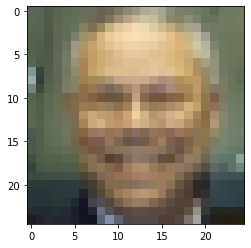

In [35]:
plt.imshow(x_train[3,:,:,:])
plt.show()

In [36]:
## DEFINE A DATA AUGMENTATION GENERATOR

batch_size = 128 
epochs = 75

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  
  return model

  
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,32)
model=CBGN(model,64)
model=CBGN(model,64)

model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()


## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 25, 25, 32)        896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
gaussian_noise_12 (GaussianN (None, 25, 25, 32)        0         
_________________________________________________________________
activation_20 (Activation)   (None, 25, 25, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 12, 12, 32)       

In [37]:
## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

Epoch 1/75
83/82 [==============================] - 84s 1s/step - loss: 0.5109 - accuracy: 0.7704 - val_loss: 0.6250 - val_accuracy: 0.7749
Epoch 2/75
83/82 [==============================] - 68s 825ms/step - loss: 0.4310 - accuracy: 0.8005 - val_loss: 0.5310 - val_accuracy: 0.7749
Epoch 3/75
83/82 [==============================] - 64s 777ms/step - loss: 0.3840 - accuracy: 0.8313 - val_loss: 0.3999 - val_accuracy: 0.8505
Epoch 4/75
83/82 [==============================] - 70s 839ms/step - loss: 0.3501 - accuracy: 0.8507 - val_loss: 0.3914 - val_accuracy: 0.8739
Epoch 5/75
83/82 [==============================] - 63s 760ms/step - loss: 0.3071 - accuracy: 0.8716 - val_loss: 0.3149 - val_accuracy: 0.8780
Epoch 6/75
83/82 [==============================] - 61s 729ms/step - loss: 0.2754 - accuracy: 0.8862 - val_loss: 0.3401 - val_accuracy: 0.8448
Epoch 7/75
83/82 [==============================] - 64s 770ms/step - loss: 0.2574 - accuracy: 0.8925 - val_loss: 0.2278 - val_accuracy: 0.9184
Ep

KeyboardInterrupt: 

In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10585, 50, 50, 3)
(2648, 50, 50, 3)
(10585,)
(2648,)
